In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import seaborn as sns
import statsmodels

In [279]:
df = pd.read_csv("../data/parsed_data_2.csv")
df['radiant_win'] = df['radiant_win'].apply(lambda x: 1 if x==True else  0)
print(df.columns)
for i in range(5,25,5):
    sum_r = 0
    sum_d = 0
    for j in range(1,6):
        sum_r+= df["radiant_position_"+str(j)+"_networth_"+str(i)]
        sum_d+= df["dire_position_"+str(j)+"_networth_"+str(i)]
    df["radiant_networth_"+str(i)] = sum_r
    df["dire_networth_"+str(i)] = sum_d


Index(['match_id', 'game_mode', 'game_duration', 'radiant_score', 'dire_score',
       'average_rank', 'radiant_win', 'dire_win', 'winner',
       'radiant_position_4_steam_id',
       ...
       'radiant_networth_lead_15', 'dire_networth_lead_15',
       'radiant_towers_lost_15', 'dire_towers_lost_15', 'radiant_kills_20',
       'dire_kills_20', 'radiant_networth_lead_20', 'dire_networth_lead_20',
       'radiant_towers_lost_20', 'dire_towers_lost_20'],
      dtype='object', length=693)


In [4]:
def generate_columns(include_dire = False, include_rad = True):
    req_columns = ["average_mmr", 'radiant_win']
    for i in range(1, 6):
        req_columns.append("radiant_position_" + str(i) +"_hero" )
        req_columns.append("dire_position_" + str(i) +"_hero" )
        for j in range(5, 25, 5):
            if include_rad:
                req_columns.append("radiant_position_" + str(i) +"_networth_"+str(j))
            if include_dire:
                req_columns.append("dire_position_" + str(i) +"_networth_"+str(j))
    return req_columns

def get_columns_for(team, data_point,range = None,  time=None):
    req_columns = []
    if range:
        for i in range:
            if time:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point+"_"+str(time))
            else:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point)
    else:
        if time:
            return [team+"_"+data_point+"_"+str(time)]
        return [team+"_"+data_point]
    return req_columns


def get_hero_filtered_df(df, num_allowed_heroes):
    dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
    radiant_heroes_cols = get_columns_for( "radiant", "hero", range(1,6))
    hero_cols = dire_heroes_cols + radiant_heroes_cols
    filtered_df = df
    for col in hero_cols:
        filter_keys = filtered_df[col].value_counts()[:num_allowed_heroes].keys()
        filtered_df = filtered_df.loc[filtered_df[col].isin(filter_keys)]
    return filtered_df

def get_formula_for_heroes_and_networth(include_heroes = True, include_networth=[True, False], networth_time=10):
    formula = ""
    if include_heroes:
        dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
        radiant_heroes_cols = get_columns_for("radiant", "hero", range(1,6))
        cols = dire_heroes_cols + radiant_heroes_cols
        formula +=  cols[0]
        for col in cols[1:]:
            formula = formula + "+" + col
    if len(include_networth) > 0:
        radiant_networth_cols = get_columns_for("radiant", "networth", range(1,6), networth_time)
        dire_net_cols =  get_columns_for("dire", "networth", range(1,6), networth_time)
        cols = []
        if include_networth[0]:
            cols +=  radiant_networth_cols
        if include_networth[1]:
            cols +=  dire_net_cols
        for col in cols:
            formula = formula + "+" + col
    return formula

def get_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + " +col
    return formula

def get_cat_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + C(" +col+")"
    return formula

def normalize_cols(df, team, data_point,range=None, time=None):
    cols = get_columns_for(team, data_point, range, time)
    for col in cols:
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

def convert_networth_to_ratio(df, team, time):
    cols = get_columns_for(team, "networth", range(1,6), time)
    for col in cols:
        df[col] = df[col]/df[team+"_networth_"+str(time)]
    return df

In [258]:
def exclude_outliers(df, time):
    col = "radiant_networth_lead_"+str(time)
    normalized = df
    normalized[col] =  (df[col]-df[col].mean())/df[col].std()
    normalized = normalized[np.abs(normalized[col]) < 1]
    return normalized

In [140]:
def one_hot(df, col):
    one_hot = pd.get_dummies(df[col], prefix=col, dtype=int)
    # Drop column B as it is now encoded
    df = df.drop(col,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

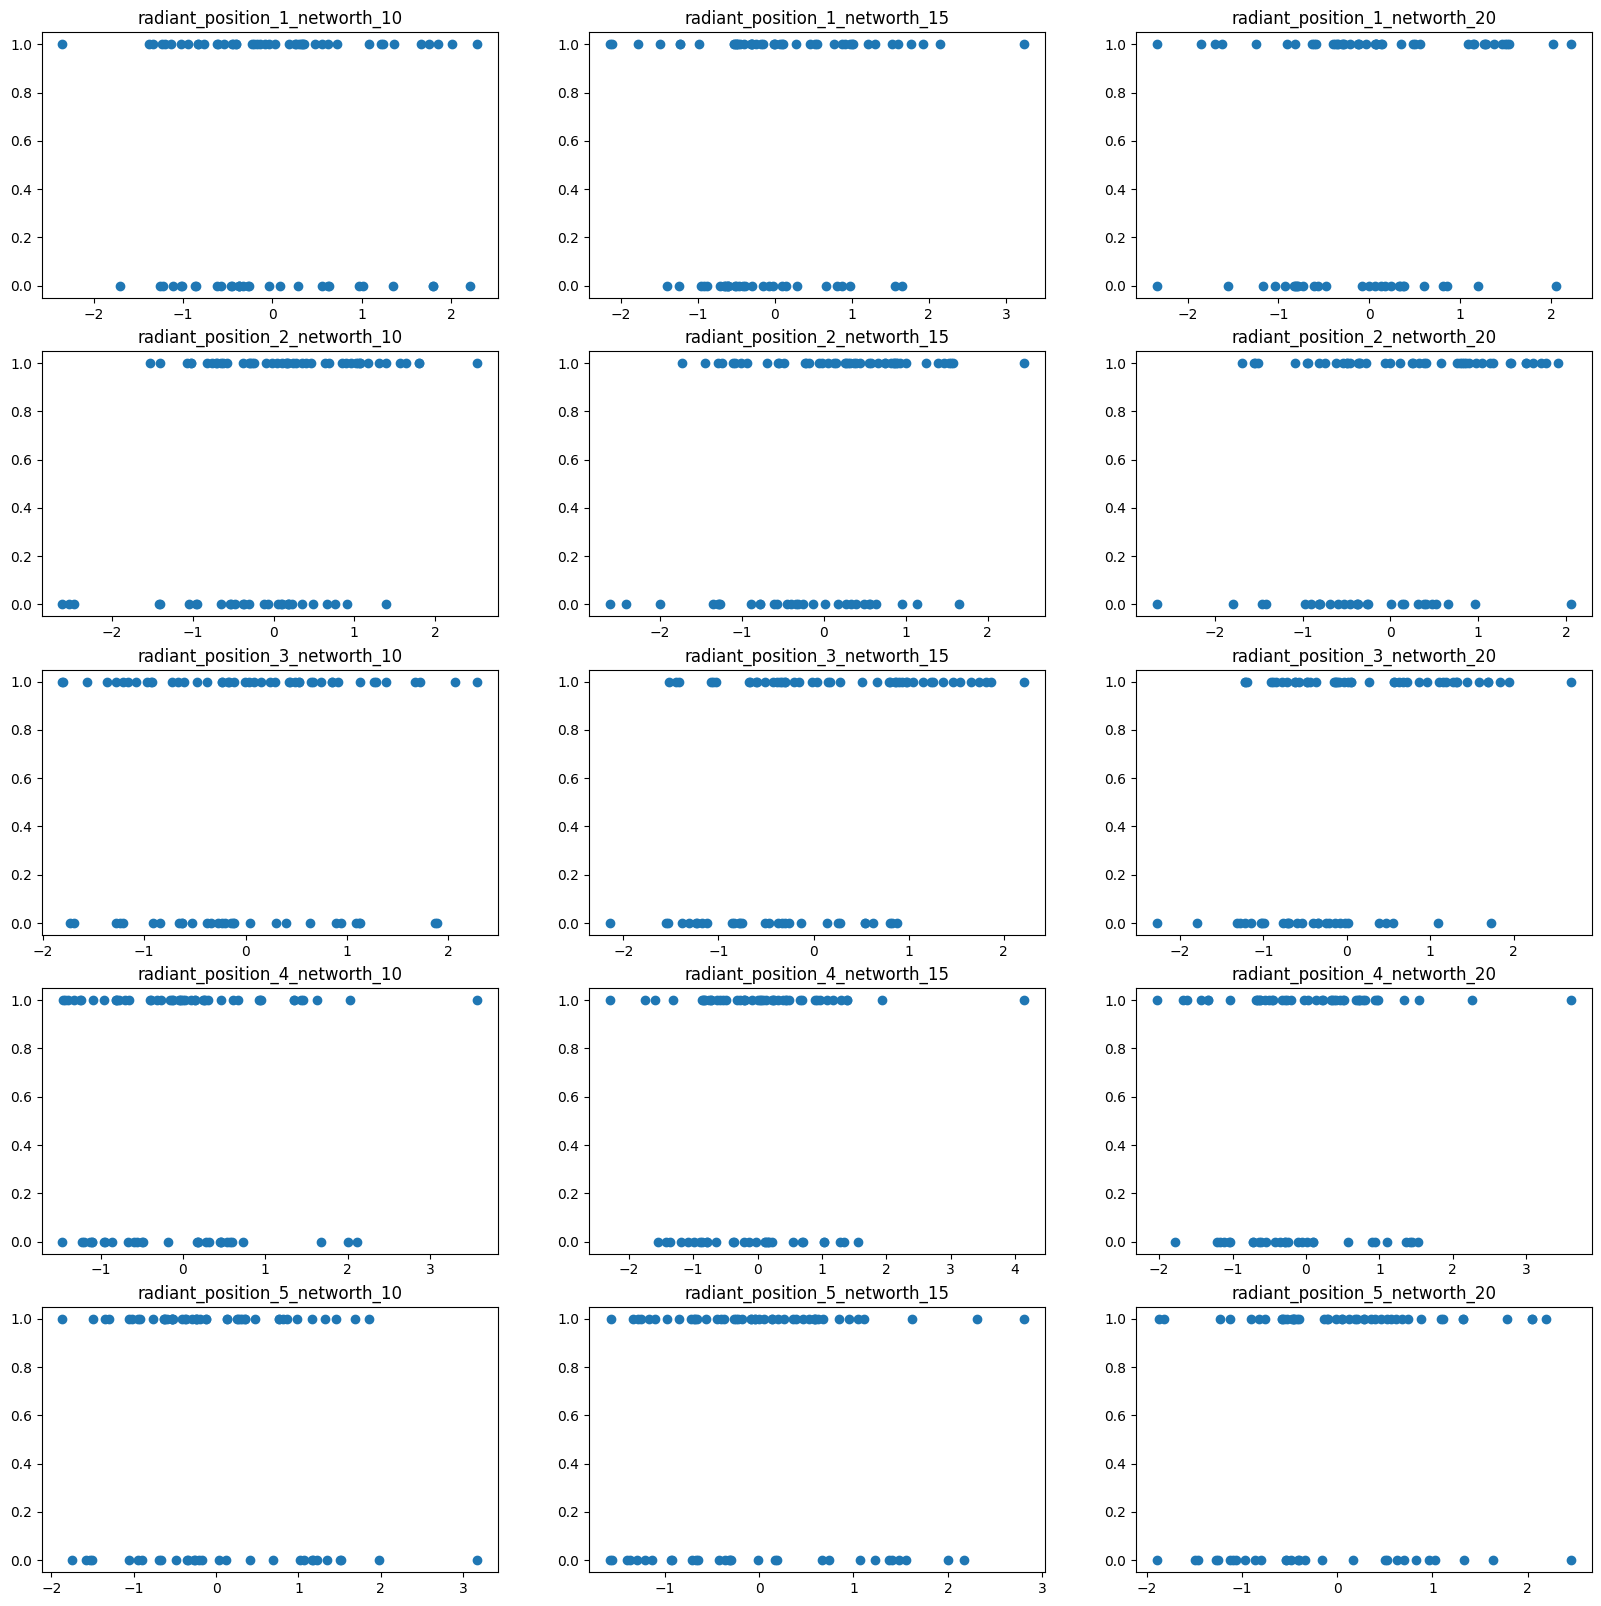

In [6]:
filtered = get_hero_filtered_df(df, 20)

fig, ax = plt.subplots(5,3)
fig.set_figwidth(20)
fig.set_figheight(20)
for i in range(1, 6):
    for j in range(10, 25, 5):
        col = "radiant_position_"+str(i)+"_networth_"+str(j)
        normalized=(filtered[col]-filtered[col].mean())/filtered[col].std()
        ax[i-1][int(j/5)-2].scatter(normalized, filtered["radiant_win"])
        ax[i-1][int(j/5)-2].set_title(col)


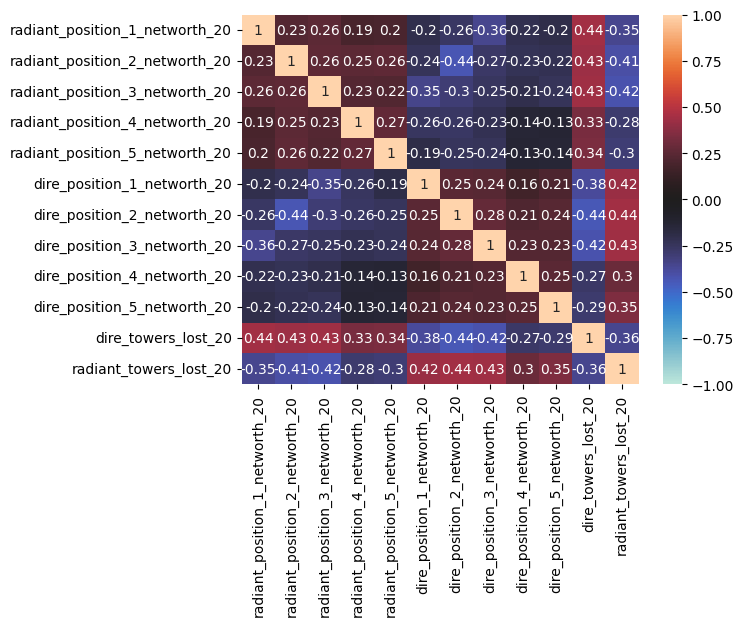

In [290]:
columns = []
columns.extend(get_columns_for("radiant", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "gpm", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "kills", time=20))
columns.extend(get_columns_for("dire", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "networth", time=20))
#columns.extend(get_columns_for("radiant", "xpm", range(1,6), 20))
#columns.extend(get_columns_for("dire", "xpm", range(1,6), 20))
columns.extend(get_columns_for("dire", "towers_lost", time=20))
columns.extend(get_columns_for("radiant", "towers_lost", time= 20))
sns.heatmap(df[columns].corr(numeric_only=True),annot=True, center=0, vmax=1, vmin=-1)
x = df


In [291]:
test_time = 20
formula = ""
#formula += get_formula_for("radiant", "networth", range(1, 6), time=test_time) 
formula += "+"+get_formula_for("dire", "networth", range(1, 6), time=test_time) 

#formula += "+"+get_formula_for("radiant", "gpm", range(1, 6), time=test_time) 
#formula += "+"+get_formula_for("dire", "gpm", range(1, 6), time=test_time)
#formula += "+"+ get_formula_for("radiant", "networth",time=test_time) 
#formula += "+"+ get_formula_for("dire", "networth",time=test_time) 
#formula += "+"+get_formula_for("radiant", "hero", range(1, 6))
#formula += "+"+get_cat_formula_for("dire", "hero", range(1, 6))
#formula += "+"+get_cat_formula_for("radiant", "hero", range(1, 6))
#formula += "+"+get_formula_for("radiant", "kills", time=test_time)
#formula += "+"+get_formula_for("dire", "kills", time=test_time)
#formula += "+"+get_formula_for("radiant", "xpm",range(1,6), time=test_time)
#formula += "+"+get_formula_for("dire", "xpm",range(1,6), time=test_time)
formula +="+"+ get_formula_for("dire", "towers_lost", time=test_time)
formula += "+"+get_formula_for("radiant", "towers_lost", time=test_time)
normalized_df = get_hero_filtered_df(df, 55)
#normalized_df = one_hot(normalized_df, get_columns_for("radiant", "hero", range(1, 6))[0])
#normalized_df = convert_networth_to_ratio(normalized_df, "radiant", test_time)
#normalized_df = normalize_cols(normalized_df,"radiant", "networth", time=test_time )
#normalized_df = normalize_cols(normalized_df,"dire", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant","networth", range(1, 6),time=test_time )
#print(normalized_df[get_columns_for("radiant", "networth", range(1, 6), time=test_time)].head())
normalized_df = normalize_cols(normalized_df,"radiant", "xpm", range(1, 6), time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "kills", time=test_time )
#normalized_df = normalize_cols(normalized_df,"dire", "networth",range(1, 6),time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "xpm", range(1, 6), time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "kills", time=test_time )
normalized_df = exclude_outliers(normalized_df, test_time)
dota_model = logit(
"radiant_win ~ " + formula,
normalized_df,
)
mlefit  = dota_model.fit()
marginal = mlefit.get_margeff()
print(mlefit.summary())

Optimization terminated successfully.
         Current function value: 0.617266
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            radiant_win   No. Observations:                 1581
Model:                          Logit   Df Residuals:                     1573
Method:                           MLE   Df Model:                            7
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.1073
Time:                        14:58:21   Log-Likelihood:                -975.90
converged:                       True   LL-Null:                       -1093.2
Covariance Type:            nonrobust   LLR p-value:                 4.984e-47
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       8.6030      0.890      9.666      0.000   

## Diagnostic Tests

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


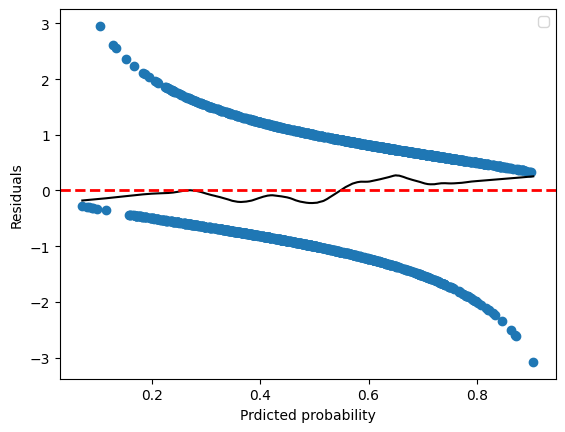

In [287]:
valid_indices = mlefit.resid_pearson.index
test_data = normalized_df[normalized_df.index.isin(valid_indices)]
test_cols = formula.split("+")
test_cols = [x.strip() for x in test_cols]
fig, ax = plt.subplots(1,1)
predicted_probabilities = mlefit.predict(test_data)
ax.scatter( predicted_probabilities, mlefit.resid_pearson)
ax.set_xlabel("Prdicted probability")
X = sm.add_constant(normalized_df[test_cols])
ax.set_ylabel("Residuals")
smoothed = sm.nonparametric.lowess(exog=predicted_probabilities, endog=mlefit.resid_pearson, frac=0.2)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add horizontal line at y=0
plt.legend()